# The Marmousi model

The Marmousi model developped by [Versteeg, 1994](https://doi.org/10.1190/1.1437051) is perhaps the most known benchmark model used for seismic imaging and inversion. Let's first download it from a public repo.

In [1]:
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from SeisCL import SeisCL

url = "http://sw3d.cz/software/marmousi/little.bin/velocity.h@"
if not os.path.isfile("velocity.h@"):
    urlretrieve(url, filename="velocity.h@")
vel = np.fromfile("velocity.h@", dtype=np.float32)

vp = np.transpose(np.reshape(np.array(vel), [2301, 751]))

For inversion, we often want a coaser grid. We must also pad the model for the absorbing boundary and create the vs and rho paramters.

In [2]:
seis = SeisCL()
vp = vp[::4, ::4]
vp = np.pad(vp, ((seis.nab, seis.nab), (seis.nab, seis.nab)), mode="edge")
rho = vp * 0 + 2000
vs = vp * 0

model = {'vp':vp, 'vs':vs, 'rho':rho}

We create an instance of `SeisCL` and setup the geometry.

In [16]:
seis.N = vp.shape
seis.ND = 2
seis.dh = 16
seis.dt = dt = 6 * seis.dh / (7 * np.sqrt(2) * np.max(vp)) * 0.85
seis.NT = int(3 / seis.dt)
seis.surface_acquisition_2d()
print(seis.N, vp.shape)

(220, 608) (220, 608)


The model is now ready, with sources just outside the CMPL region.

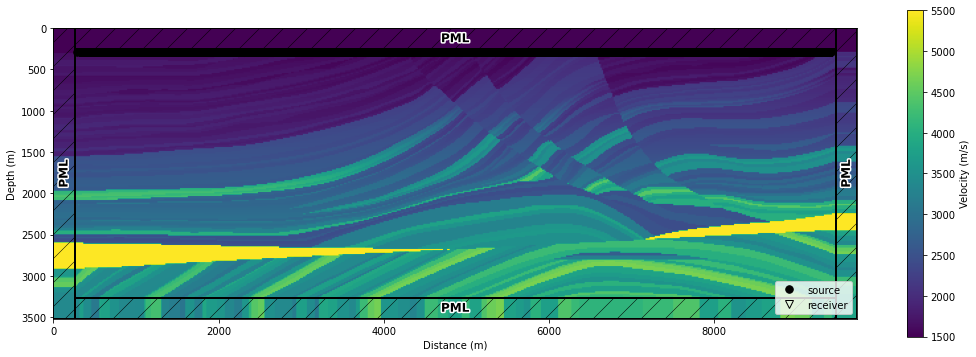

In [17]:
_, ax = plt.subplots(1, 1, figsize = (18, 6))
seis.DrawDomain2D(vp, ax = ax, showabs=True, showsrcrec=True)

Let's compute the seismograph for source 50.

In [21]:
seis.set_forward([50], model, withgrad=False)
seis.execute()
data = seis.read_data()

The figure showing the recorded data is finally created.

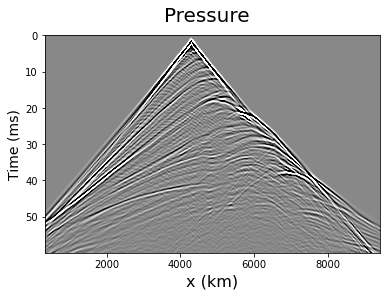

In [20]:
p = data[0]
xmin = np.min(seis.rec_pos_all[0, :])
xmax = np.max(seis.rec_pos_all[0, :])
clip=0.01;
vmin=np.min(p)*clip;
vmax=np.max(p)*clip;
fig, ax = plt.subplots()
im = ax.imshow(p, 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[xmin,xmax, p.shape[0]*seis.dt*20,0]
               )
fig.suptitle('Pressure', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()